In [1]:
import numpy as np
import torch
import gymnasium as gym
from gymnasium import spaces

import imageio
import os
import random

from Dueling_DQN_Agent.Dueling_DQN_Agent import Dueling_DQN_Agent
import Dueling_DQN_Agent.utils.help_classes as hc
import Dueling_DQN_Agent.utils.stats_functions as sf

import hockey.hockey_env as h_env

from importlib import reload


In [2]:
SEED_TRAIN_1 = 7489
SEED_TRAIN_2 = 1312
SEEDS_TEST = [291, 292, 293, 294, 295]

seed = SEED_TRAIN_1

In [10]:
reload(h_env)
env_name = "Hockey_test_3"
env = h_env.HockeyEnv()
"""if isinstance(env.action_space, spaces.Box):
    env = hc.DiscreteActionWrapper(env,5)"""

# Initialize the agent with the correct state/action space
state_space = env.observation_space
action_space = env.discrete_action_space

#agent = Dueling_DQN_Agent(state_space, action_space, use_eps_decay = True, seed = seed)
agent = Dueling_DQN_Agent(state_space, action_space, seed = seed)
agent.Q.hidden_sizes = [256, 256, 128]
opponent = h_env.BasicOpponent()

stats = []
losses = []

max_episodes = 8000
train_iterations = 32  # Number of training steps per episode

max_steps = 20000

for episode in range(max_episodes):

    state, _ = env.reset(seed = seed)
    state = state[0] if isinstance(state, tuple) else state  # Handle Gymnasium compatibility

    obs_agent2 = env.obs_agent_two()
    obs_agent2 = obs_agent2[0] if isinstance(obs_agent2, tuple) else obs_agent2

    total_reward = 0
    
    for t in range(max_steps):

        done = False
        #a1 = env.discrete_to_continous_action(agent.perform_greedy_action(state))
        a1 = agent.perform_greedy_action(state)
        a2 = opponent.act(obs_agent2)
        full_action = np.hstack([env.discrete_to_continous_action(a1), a2])

        """print(f"a1: {a1}, shape: {np.asarray(a1).shape}")
        print(f"a2: {a2}, shape: {np.asarray(a2).shape}")
        print(f"full action: {full_action}, shape: {full_action.shape}")"""

        next_state, reward, done, truncated, _ = env.step(full_action)
        
        total_reward += reward

        agent.buffer.add_transition((state, a1, reward, next_state, done))      # Store transition in the agent"s memory and then train

        state = next_state
        obs_agent2 = env.obs_agent_two()

        if done or truncated: break
        
    losses.extend(agent.train(train_iterations))
    stats.append([episode, total_reward, t + 1])
    
    if agent._config["use_eps_decay"] and episode > int(0.5 * max_episodes):
        agent._perform_epsilon_decay()

    print(f"Episode {episode+1}/{max_episodes}, Total Reward: {total_reward}")
        
    if ((episode) % int(max_episodes/10) == 0) and episode > 0:
        agent.Q.save(env_name, name = f"episode_{episode}")

agent.Q.save(env_name, name = "training_finished")
sf.save_stats(env_name, stats, losses)


/home/pablosbl/Documents/GitHub/hockey-en-mallorca/.venv/lib/python3.10/site-packages/gymnasium/envs/registration.py:642: UserWarning: WARN: Overriding environment Hockey-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")
/home/pablosbl/Documents/GitHub/hockey-en-mallorca/.venv/lib/python3.10/site-packages/gymnasium/envs/registration.py:642: UserWarning: WARN: Overriding environment Hockey-One-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")


Episode 1/8000, Total Reward: -8.514904453695417
Episode 2/8000, Total Reward: -12.548988599327808
Episode 3/8000, Total Reward: -11.954775688631024
Episode 4/8000, Total Reward: -50.11562187174646
Episode 5/8000, Total Reward: -15.462073811868006
Episode 6/8000, Total Reward: -35.98568615646589
Episode 7/8000, Total Reward: -12.012778950163344
Episode 8/8000, Total Reward: -30.712578181411143
Episode 9/8000, Total Reward: -11.88826478630936
Episode 10/8000, Total Reward: -29.512488278629064
Episode 11/8000, Total Reward: -11.265556579321187
Episode 12/8000, Total Reward: -1.2734912213721004
Episode 13/8000, Total Reward: -11.814848601191935
Episode 14/8000, Total Reward: -13.110745457561427
Episode 15/8000, Total Reward: -12.431770744726368
Episode 16/8000, Total Reward: -12.32382495290969
Episode 17/8000, Total Reward: -12.817399665975906
Episode 18/8000, Total Reward: 9.312255111402326
Episode 19/8000, Total Reward: -11.69777819730006
Episode 20/8000, Total Reward: -13.4781156897969

Plot saved at Hockey_test_3/stats/plots/returns_plot.png


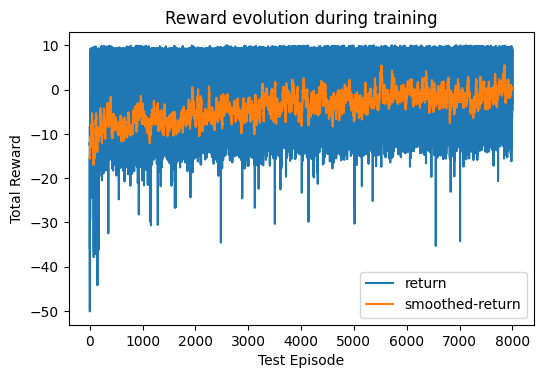

In [11]:
sf.plot_returns(stats, env_name)

Plot saved at Hockey_test_3/stats/plots/losses_plot.png


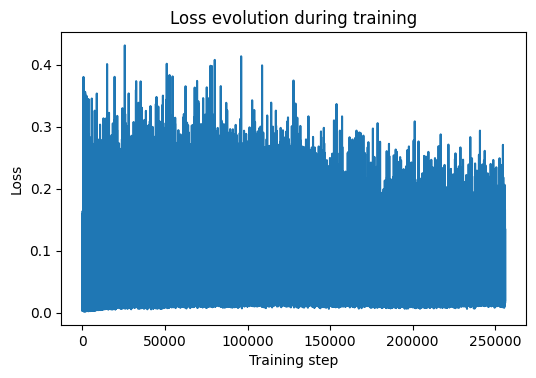

In [12]:
sf.plot_losses(losses, env_name)

## Testing the agent

In [ ]:
agent = Dueling_DQN_Agent(state_space, action_space, seed = seed)
agent.Q.load(env_name)

Test Episode 1, Total Reward: -0.17763173687611006
Test Episode 2, Total Reward: 8.703158012048746
Test Episode 3, Total Reward: -0.10637569596465056
Test Episode 4, Total Reward: 8.534130010892635
Test Episode 5, Total Reward: -11.885715162042805
Plot saved at Hockey_test_2/stats/plots/test_results.png


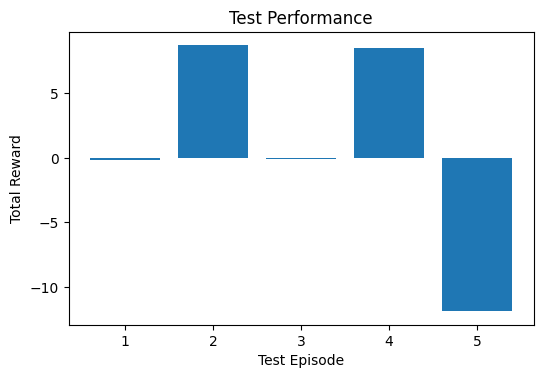

In [7]:
env = h_env.HockeyEnv()

test_episodes = len(SEEDS_TEST)
test_rewards = []

max_steps = 1000

for episode in range(test_episodes):

    state, _ = env.reset(seed = SEEDS_TEST[episode])
    state = state[0] if isinstance(state, tuple) else state  # Handle Gymnasium compatibility

    obs_agent2 = env.obs_agent_two()
    obs_agent2 = obs_agent2[0] if isinstance(obs_agent2, tuple) else obs_agent2

    total_reward = 0

    frames = []
    
    for t in range(max_steps):

        done = False

        frame = env.render(mode = "rgb_array")
        if frame is not None:
            frames.append(frame)

        #a1 = env.discrete_to_continous_action(agent.perform_greedy_action(state))
        a1 = agent.perform_greedy_action(state, eps = 0.0)
        a2 = opponent.act(obs_agent2)
        full_action = np.hstack([env.discrete_to_continous_action(a1), a2])

        next_state, reward, done, truncated, _ = env.step(full_action)
        
        total_reward += reward

        agent.buffer.add_transition((state, a1, reward, next_state, done))      # Store transition in the agent"s memory and then train

        state = next_state
        obs_agent2 = env.obs_agent_two()

        if done or truncated: break

    test_rewards.append(total_reward)
    print(f"Test Episode {episode+1}, Total Reward: {total_reward}")
    
    if frames:
        os.makedirs(f"{env_name}/test_gifs", exist_ok=True)
        imageio.mimsave(f"{env_name}/test_gifs/test_episode_{episode+1}.gif", frames, fps=30)

env.close()

sf.save_test_results(env_name, test_rewards)